<a href="https://colab.research.google.com/github/vokashlob/OTUS/blob/main/OTUS_overfitting_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ИМПОРТ

In [79]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline

## ПАРАМЕТРЫ


In [80]:
batch_size = 64
learning_rate = 1e-4
epochs = 5
l2 = 0


## ЗАГРУЖАЕМ ДАННЫЕ

In [81]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## ТЕСТОВАЯ ОТРИСОВКА

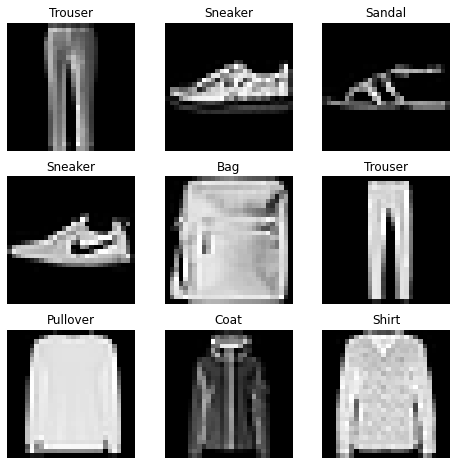

In [82]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Размер батча с фичами: torch.Size([64, 1, 28, 28])
Размер батча с метками: torch.Size([64])


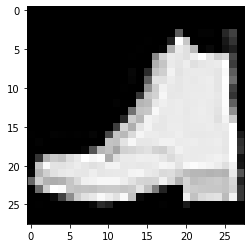

Метка: Ankle Boot


In [83]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Размер батча с фичами: {train_features.size()}")
print(f"Размер батча с метками: {train_labels.size()}")
img = train_features[0].squeeze()
label = labels_map[train_labels[0].item()]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Метка: {label}")

## GPU TEST

In [84]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## СТРОИМ МОДЕЛЬ (без batchnorm и dropout)

In [85]:
class NeuralNetwork(nn.Module):
    def __init__(self, lr=learning_rate, l2=l2):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

print("Структура модели: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Слой: {name} | Размер: {param.size()} | Значения : {param[:2]} \n")

Структура модели:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
) 


Слой: linear_relu_stack.0.weight | Размер: torch.Size([512, 784]) | Значения : tensor([[ 0.0290,  0.0282,  0.0249,  ...,  0.0077,  0.0305,  0.0064],
        [-0.0344,  0.0167, -0.0103,  ...,  0.0260, -0.0255, -0.0085]],
       device='cuda:0', grad_fn=<SliceBackward>) 

Слой: linear_relu_stack.0.bias | Размер: torch.Size([512]) | Значения : tensor([ 0.0325, -0.0347], device='cuda:0', grad_fn=<SliceBackward>) 

Слой: linear_relu_stack.2.weight | Размер: torch.Size([512, 512]) | Значения : tensor([[-0.0036, -0.0078, -0.0037,  ...,  0.0228,  0.0325, -0.0220],
        [-0.0154,  0.0123,  0.0301,  ...,  0.0020, -0.0116, -0.0190]],
       de

In [86]:
loss_fn = nn.CrossEntropyLoss()
optimtzer = optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2)
train_log = []
test_log = []

In [107]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        if train_log is not None:
          train_log.append(loss)


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
            
            if test_log is not None:
              test_log.append(test_loss)

    test_loss /= size
    correct /= size

    


    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [108]:
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Готово!")

Эпоха 1
-------------------------------
loss: 2.267772  [    0/60000]
loss: 2.277132  [ 6400/60000]
loss: 2.254688  [12800/60000]
loss: 2.272145  [19200/60000]
loss: 2.269969  [25600/60000]
loss: 2.279720  [32000/60000]
loss: 2.263507  [38400/60000]
loss: 2.278184  [44800/60000]
loss: 2.285237  [51200/60000]
loss: 2.256290  [57600/60000]
Test Error: 
 Accuracy: 37.8%, Avg loss: 0.035521 

Эпоха 2
-------------------------------
loss: 2.264753  [    0/60000]
loss: 2.262725  [ 6400/60000]
loss: 2.250156  [12800/60000]
loss: 2.266549  [19200/60000]
loss: 2.252374  [25600/60000]
loss: 2.251401  [32000/60000]
loss: 2.240708  [38400/60000]
loss: 2.237246  [44800/60000]
loss: 2.252260  [51200/60000]
loss: 2.264173  [57600/60000]
Test Error: 
 Accuracy: 38.6%, Avg loss: 0.035410 

Эпоха 3
-------------------------------
loss: 2.267110  [    0/60000]
loss: 2.242420  [ 6400/60000]
loss: 2.255274  [12800/60000]
loss: 2.260228  [19200/60000]
loss: 2.261232  [25600/60000]
loss: 2.252827  [32000/600

In [110]:
len(test_log)

790

In [111]:
len(train_log)

9380

In [1]:
plt.plot(len(test_log, test_log))

NameError: ignored